# Exploración de *Iris*
Se pretende explorar el famoso [conjunto de datos iris](https://archive.ics.uci.edu/ml/datasets/Iris), introducido por Ronal Fisher, y seleccionar un modelo que permita realizar una buena clasificación de las especies de cada flor iris.

Así, primero se realiza un análisis exploratorio y después se evaluan varios modelos entre los cuales se elige el que tenga un menor error de clasificación.

## Importación de librerías
Se trabajarán con las siguientes librerías:
* Pandas: Manejo de *dataframes*.
* Numpy: Diversas operaciones matemáticas.
* Scikit-learn: Empleo de modelos predictivos.
* Graphviz, Matplotlib, Seaborn: Gráficos.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import tree

## Carga de datos y análisis exploratorio

Primero, se deben cargar los datos; con esto, se exploran los valores que toman las variables, la presencia de valores perdidos y algunos estadísticos univariados.

In [2]:
data = pd.read_csv("../datasets/iris.data", sep = ",",
                   names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"])
data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
data.isna().mean()

sepal_length    0.0
sepal_width     0.0
petal_length    0.0
petal_width     0.0
class           0.0
dtype: float64

In [4]:
cols = data.columns.values
iris_class = data['class'].replace(to_replace = '\w*-', value = '', regex = True)
data['class'] = iris_class
data['class'].describe()

count        150
unique         3
top       setosa
freq          50
Name: class, dtype: object

In [5]:
data.describe().applymap(lambda x: f"{x:0.2f}")

,sepal_length,sepal_width,petal_length,petal_width
count,150.00,150.00,150.00,150.00
mean,5.84,3.05,3.76,1.20
std,0.83,0.43,1.76,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


Se realiza una observación gráfica a la distribución de cada variable mediante el empleo de histogramas.

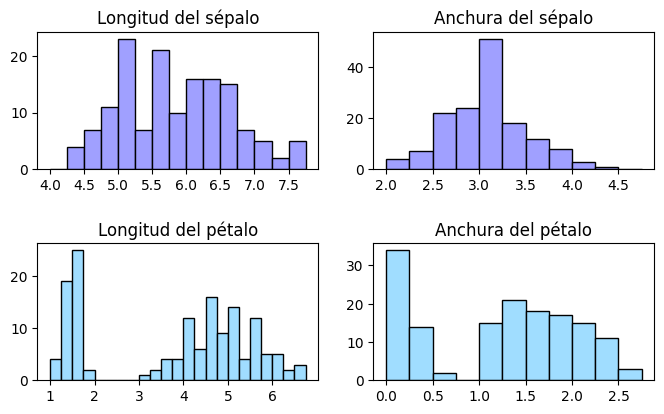

In [6]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(4.5)
fig.set_figwidth(7)
for col, ax in zip(cols[:-1], axes.ravel()):    
    step = 0.5
    min_val = np.floor(data[col].min())
    max_val = np.ceil(data[col].max())
    if bool(re.search('sepal',col)):
        color = '#A0A0FF'
        if bool(re.search('length',col)):
            title = 'Longitud del sépalo'
        else:
            title = 'Anchura del sépalo'
    elif bool(re.search('petal',col)):
        color = '#A0DDFF'      
        if bool(re.search('length',col)):
            title = 'Longitud del pétalo'
            step = 1
        else:
            title = 'Anchura del pétalo'
    ax.hist(data[col], edgecolor = 'black', color = color, bins = np.arange(min_val, max_val, 0.25))
    ax.set_title(title)
    ax.set_xticks(np.arange(min_val,max_val, step))
fig.tight_layout(pad = 2)
plt.show()

Ahora, se desea saber cómo varían los estadísticos de las variable respecto a cada especie. Además, de manera similar, se generan histogramas, pero esta vez teniendo en cuenta la diferencia entre especies.

In [7]:
desc_cols = [(c,m) for c in data.columns[:-1] for m in ['count','mean','std']]
data.groupby('class').describe().loc[:,desc_cols].applymap(lambda x: f"{x:0.4f}")

sepal_length                 sepal_width                  \
                  count    mean     std       count    mean     std   
class                                                                 
setosa          50.0000  5.0060  0.3525     50.0000  3.4180  0.3810   
versicolor      50.0000  5.9360  0.5162     50.0000  2.7700  0.3138   
virginica       50.0000  6.5880  0.6359     50.0000  2.9740  0.3225   

           petal_length                 petal_width                  
                  count    mean     std       count    mean     std  
class                                                                
setosa          50.0000  1.4640  0.1735     50.0000  0.2440  0.1072  
versicolor      50.0000  4.2600  0.4699     50.0000  1.3260  0.1978  
virginica       50.0000  5.5520  0.5519     50.0000  2.0260  0.2747

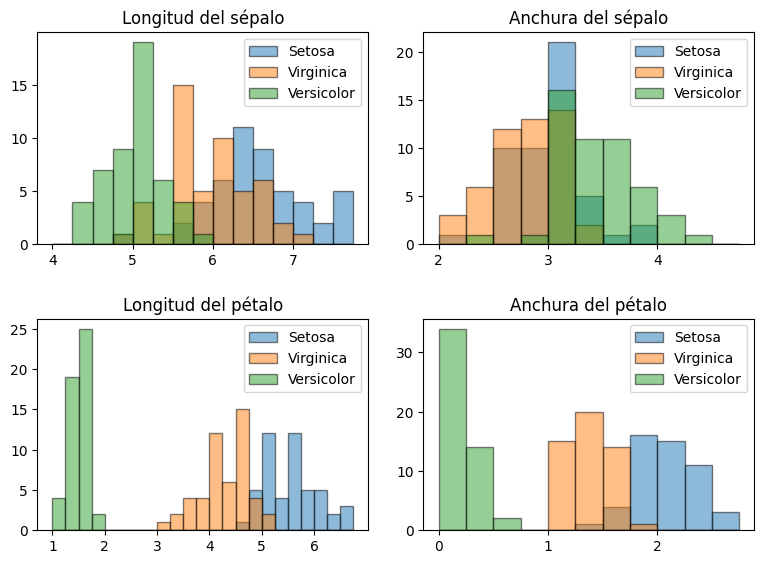

In [8]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(8)
for col, ax in zip(cols[:-1], axes.ravel()):
    if bool(re.search('sepal',col)):
        color = '#A0A0FF'
        if bool(re.search('length',col)):
            title = 'Longitud del sépalo'
        else:
            title = 'Anchura del sépalo'
    elif bool(re.search('petal',col)):
        color = '#A0DDFF'      
        if bool(re.search('length',col)):
            title = 'Longitud del pétalo'
            step = 1
        else:
            title = 'Anchura del pétalo'
    for ic in set(iris_class):
        step = 0.25
        min_val = np.floor(data[col].min())
        max_val = np.ceil(data[col].max())    
        ax.hist(data[data['class'] == ic][col], edgecolor = 'black', bins = np.arange(min_val, max_val, step), alpha = 0.5)
        ax.set_title(title)
        ax.set_xticks(np.arange(min_val,max_val, step*4))
        ax.legend(['Setosa', 'Virginica', 'Versicolor'])
fig.tight_layout(pad = 2)
plt.show()

La correlación que existe entre las variables puede ser también información útil. Como se puede observar, existe una correlación muy alta entre *petal_length* con *petal_width*, aunque también destacan *petal_length* con *sepal_length* y *petal_width* con *sepal_length*.

In [9]:
data_corr = data.iloc[:,:-1].corr()
data_corr

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


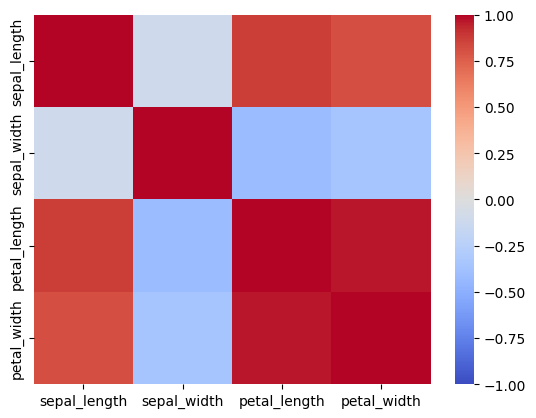

In [10]:
sns.heatmap(data_corr, cmap = 'coolwarm',
            xticklabels=data_corr.columns,
            yticklabels=data_corr.columns,
            vmin = -1, vmax = 1)
plt.show()

In [11]:
X = data[cols[:-1]]
y = data[cols[-1:]]

### Clustering
En este apartado, se pretende hacer un clustering exploratorio, para observar la existencia de patrones entre clases en las diversas dimensiones de cada flor. A pesar de saber que hay tres especies de flores especificadas en el conjunto de datos, se utilizará el método del codo para validar si la selección de tres cluster es adecuada.

In [12]:
wcs = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, n_init = 30, random_state = 2009).fit(X)
    wcs.append(kmeans.inertia_)

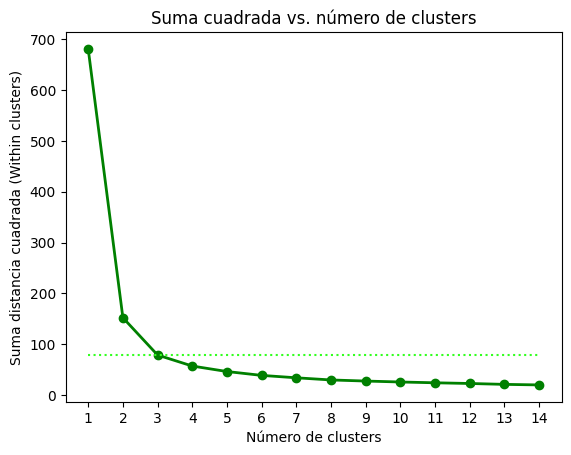

In [13]:
plt.plot(range(1, 15), wcs, '-o', color = 'green', linewidth = 2)
plt.xticks(range(1,15,1))
plt.hlines(wcs[2], xmin = 1, xmax = 14, linestyle = 'dotted', color = '#33FF21')
plt.xlabel('Número de clusters')
plt.ylabel('Suma distancia cuadrada (Within clusters)')
plt.title('Suma cuadrada vs. número de clusters')
plt.show()

Como era de esperar, se observa que, después del tercer cluster, la disminución en distancia cuadrada hasta cada centro es pequeña (se ha encontrado el codo en $K=3$). Así, se eligen tres clusters para realizar el análisis.

In [14]:
kmeans = KMeans(n_clusters = 3, n_init = 30, random_state = 2009)
y_preds = kmeans.fit_predict(X)

Después de obtener los clusters utilizando *K-means*, se grafican las dimensiones de las observaciones en planos cuyas dimensiones son la anchura y la longitud. Cada gráfica representa las dimensiones del sépalo, para una, y del pétalo, para la otra.

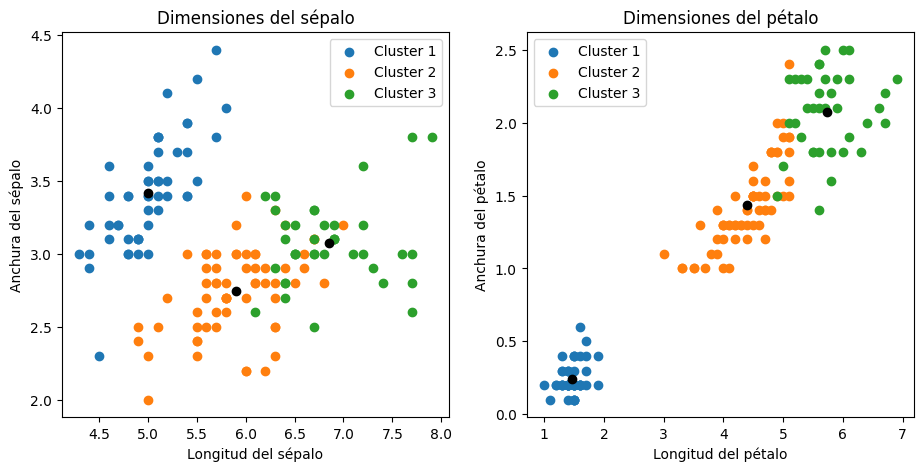

In [15]:
fig, axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(11)

axes[0].set_title('Dimensiones del sépalo')
for i in range(3):
    axes[0].scatter(X.iloc[y_preds == i,0], X.iloc[y_preds == i,1], label = 'Cluster ' + str(i+1))
    axes[0].scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], color = 'black')

axes[1].set_title('Dimensiones del pétalo')
for i in range(3):
    axes[1].scatter(X.iloc[y_preds == i,2], X.iloc[y_preds == i,3], label = 'Cluster ' + str(i+1))
    axes[1].scatter(kmeans.cluster_centers_[i,2], kmeans.cluster_centers_[i,3], color = 'black')

axes[0].set_xlabel('Longitud del sépalo')
axes[0].set_ylabel('Anchura del sépalo')
axes[0].legend()

axes[1].set_xlabel('Longitud del pétalo')
axes[1].set_ylabel('Anchura del pétalo')
axes[1].legend()

plt.show()

Se observa entonces que sí se pueden distinguir claramente los clusters para las dimensiones del pétalo y del sépalo. La diferencia es marcada para el primer cluster en las dimensiones del pétalo: parece que este grupo tiene las dimensiones más pequeñas en el pétalo, con una anchura considerable y una longitud menor en caso de las dimensiones del sépalo.

## Modelos predictivos

Ahora, se aplicarán modelos predictivos y se va a comparar el porcentaje de predicciones correctas para determinar cuál es el mejor modelo entre los que se han considerado. Para esto, lo primero que se hace es separar el conjunto de datos en un grupo de entrenamiento y otro de prueba.

* Training set: Acá se ajustarán los parámetros de cada modelo utilizando validación cruzada y se escogerá el mejor modelo a ser aplicado, considerando una función de costo a minimizar.

* Test set: Una vez que el modelo ha entrenado con el *Training set*, es hora de mostrarle datos nunca antes vistos y ver qué tan bien puede realizar las predicciones con estos.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2009)

### RandomForest
Se emplearan varios árboles de decisión utilizando la técnica del *RandomForest*, que consiste en realizar varios árboles de decisión haciendo *bootstrapping* y eligiendo aleatoriamente un subconjunto de variables a utilizar para evitar que los árboles estén correlacionados.

A manera de ejemplo, se puede observar un árbol de decisión generado para la totalidad del conjunto de datos. Cada nodo, si no es terminal, indica el criterio para decidir la especie a la que corresponde cada flor. Por ejemplo, si la longitud del pétalo es menor a 2.45 centímetros, se concluye que la flor pertenece a la clase *setosa* (con coeficiente de Gini igual a 0, 50 observaciones y en donde 50 especies pertenecen a dicha clase); caso contrario, se sigue avanzando en el árbol, en donde se observa que si la anchura del pétalo es menor a 1.75cm, se toma una decisión, y así sucesivamente.

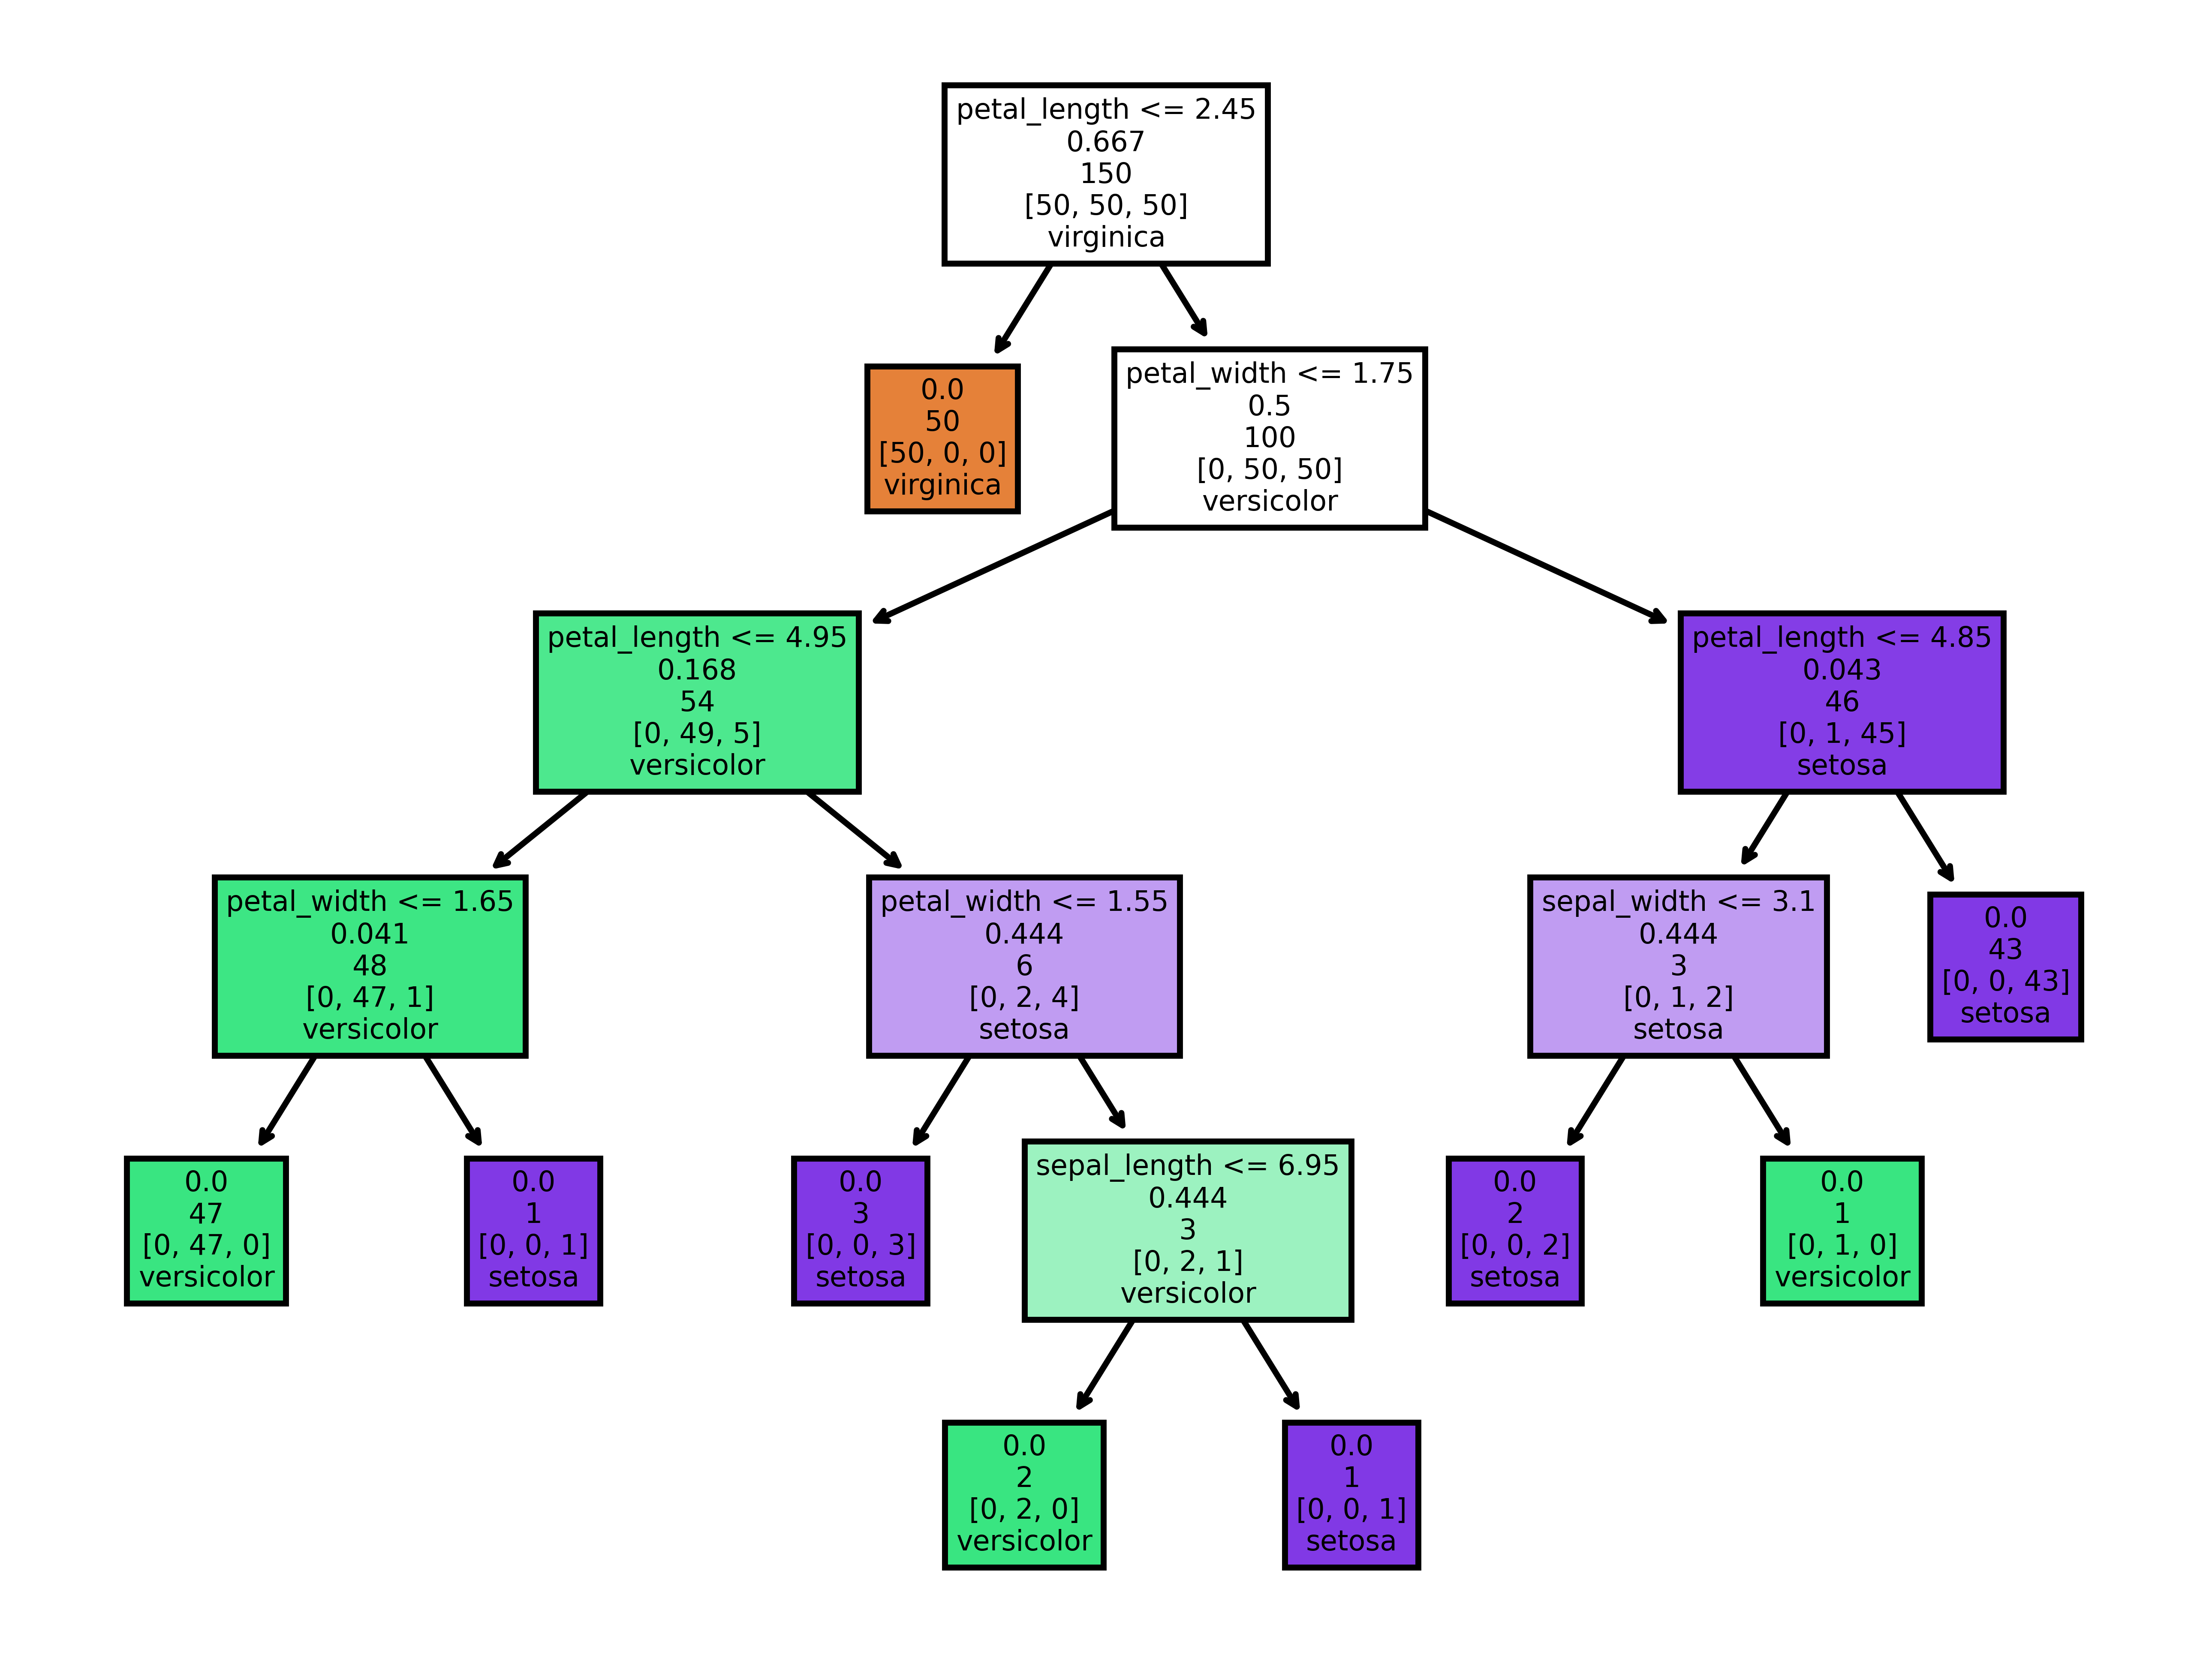

In [17]:
dtree = tree.DecisionTreeClassifier()
dtree.fit(X,y)
plt.figure(dpi = 1000)
tree.plot_tree(dtree, feature_names = cols[:-1], label = 'All',
               class_names = list(set(iris_class)), filled = 'True')
plt.show()

La idea principal del Random Forest es crear varios árboles de decisión y promediarlos. Para esto, se requiere especificar el número de árboles a utilizar, el criterio de separación y el número de variables que se utilizará para generar las separaciones.

In [18]:
rf_params = {
    'n_estimators': [ 50*i for i in range(1,11)],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', None]
}

Para escoger los mejores parámetros (es decir, aquellos parámetros que hagan que el modelo tenga el menor error posible), se realizan estimaciones del error utilizando validación cruzada para cada modelo con el parámetro especificado.

In [19]:
rf_cv = GridSearchCV(RandomForestClassifier(), param_grid= rf_params, cv = 10)
rf_cv.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', None],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]})

Así, se tienen los parámetros en donde el modelo tiene mejor rendimiento para el conjunto de entrenamiento.

In [20]:
rf_best_params = pd.DataFrame(rf_cv.best_params_, index = ['Best params'])
rf_best_params

,criterion,max_features,n_estimators
Best params,gini,sqrt,50


In [21]:
rf = RandomForestClassifier(n_estimators = rf_best_params.loc[:,'n_estimators'][0],
                            criterion = rf_best_params.loc[:,'criterion'][0],
                            max_features = 'sqrt')
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=50)

Finalmente, es posible visualizar el aporte de cada variable en la generación de los árboles de decisión. Como se puede observar, la longitud del pétalo ha contribuído más que el resto de variables en la generación de los árboles.

In [22]:
rf_feat = pd.DataFrame({'features': rf.feature_names_in_, 'importance': rf.feature_importances_}).sort_values('importance', ascending = False)

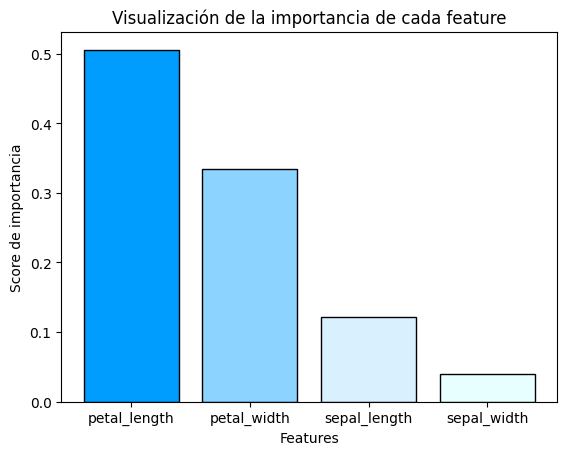

In [23]:
colors = ['#009dff', '#8cd3ff', '#d9f1ff', '#e8ffff']
plt.bar(rf_feat.features, rf_feat.importance, edgecolor = 'black', color = colors)
plt.xlabel('Features')
plt.ylabel('Score de importancia')
plt.title('Visualización de la importancia de cada feature')
plt.show()

Finalmente, se utiliza el modelo sobre el conjunto de prueba para calcular la precisión del modelo. Se observa que el modelo ha podido predecir la clase de la flor correctamente el 96.67% de las veces en un conjunto de datos que nunca antes había visto. 

In [24]:
y_pred = rf.predict(X_test)
rf_acc = metrics.accuracy_score(y_test, y_pred)

print('Random Forest accuracy: {0:.2f}%'.format(rf_acc*100))

Random Forest accuracy: 96.67%
